In [1]:
%pylab --no-import-all inline
import tensorflow as tf

import sklearn.cross_validation

from utils import *

import sys

Populating the interactive namespace from numpy and matplotlib


In [2]:
mnist = load_datasets()

In [3]:
def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)

def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                          strides=[1, 2, 2, 1], padding='SAME')

In [4]:
x = tf.placeholder(tf.float32, shape=[None, 784])
y_ = tf.placeholder(tf.float32, shape=[None, 10])

In [5]:
x_image = tf.reshape(x, [-1,28,28,1])

W_conv1 = weight_variable([5, 5, 1, 32])
b_conv1 = bias_variable([32])

h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)
h_pool1 = max_pool_2x2(h_conv1)

W_conv2 = weight_variable([5, 5, 32, 64])
b_conv2 = bias_variable([64])

h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
h_pool2 = max_pool_2x2(h_conv2)

W_fc1 = weight_variable([7 * 7 * 64, 1024])
b_fc1 = bias_variable([1024])

h_pool2_flat = tf.reshape(h_pool2, [-1, 7*7*64])
h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)

keep_prob = tf.placeholder(tf.float32)
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

W_fc2 = weight_variable([1024, 10])
b_fc2 = bias_variable([10])

y_conv=tf.nn.softmax(tf.matmul(h_fc1_drop, W_fc2) + b_fc2)

cross_entropy = -tf.reduce_sum(y_ * tf.log(y_conv))

In [6]:
sess = tf.InteractiveSession()

In [7]:
adam = tf.train.AdamOptimizer(1e-4)
train_step = adam.minimize(cross_entropy)

In [8]:
y_max = tf.argmax(y_conv, 1)

correct_prediction = tf.equal(y_max, tf.argmax(y_, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [9]:
saver = tf.train.Saver() #[W_conv1, b_conv1, W_conv2, b_conv2, W_fc1, b_fc1, W_fc2, b_fc2])

In [10]:
saver.restore(sess, "dumped_vars/conv_dirty.ckpt")

In [9]:
tf.initialize_all_variables().run()

q = []

In [ ]:
batch_generator = get_batch_generator(50, 60000)

test_batch = next(get_batch_generator(500,  10000))

for i in xrange(3000):
    batch = next(batch_generator)
    q.append(
        1 - accuracy.eval({
            x: mnist.original.test[test_batch],
            y_: one_hot(mnist.labels.test)[test_batch],
            keep_prob: 1.0
        })
    )
    if i % 1 == 0:
        sys.stderr.write("%d: %.2f%%\t" % (i, q[-1] * 100))
        sys.stderr.flush()
        if i % 5 == 0:
            sys.stderr.write('\n')
    train_step.run({
        x: mnist.original.train[batch],
        y_: one_hot(mnist.labels.train[batch]),
        keep_prob: 0.5
    })

final_correctness = []

for batch in get_batch_generator(100, 10000, 100):
    tmp_ = correct_prediction.eval({
        x: mnist.original.test[batch],
        y_: one_hot(mnist.labels.test[batch]),
        keep_prob: 1.0
    })
    final_correctness.extend(tmp_)

final_accuracy = np.mean(final_correctness)
    
sys.stderr.write("\ntest error %.2f%%\n" % (100 * (1 - final_accuracy)))

In [17]:
correctness = []
for j in range(60):
    correctness.extend(correct_prediction.eval({
        x: mnist.dirty_light.train[j*1000:(j+1)*1000],
        y_: one_hot(mnist.labels.train[j*1000:(j+1)*1000]),
        keep_prob: 1.0
    }))
    sys.stderr.write("%d, " % j)

0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 

In [16]:
save_path = saver.save(sess, "./dumped_vars/conv.ckpt")
print("Model saved in file: %s" % save_path)

Model saved in file: ./dumped_vars/conv.ckpt


2.20%


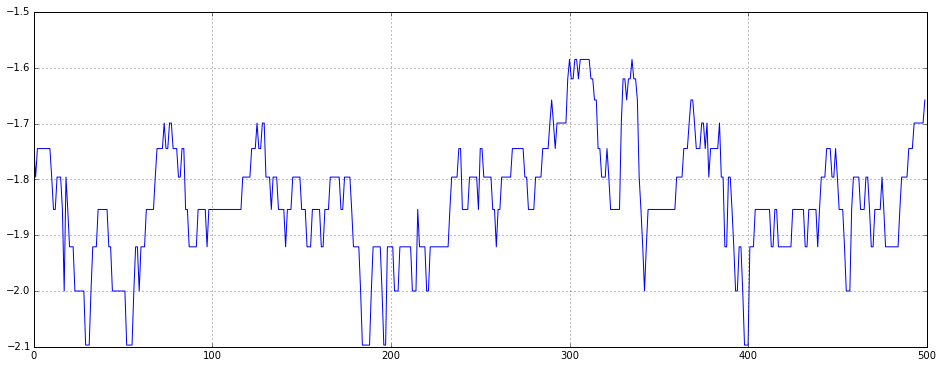

In [18]:
plt.figure(figsize=(16, 6))
plt.plot(np.log10(q[3500:]))
plt.grid()
print "%.2f%%" % (q[-1] * 100)

In [11]:
for label in ['original', 'dirty_light', 'dirty_hard']:
    test_batch = get_batch_generator(100, 10000, 100)

    _q = np.mean(map(np.mean, (accuracy.eval({
        x: mnist[label].test[batch],
        y_: one_hot(mnist.labels.test[batch]),
        keep_prob: 1.0
    }) for batch in test_batch)))
    print label, _q

original 0.9706
dirty_light 0.9319
dirty_hard 0.906


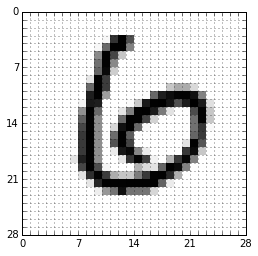

In [36]:
imgshow(mnist.original.test[11])

In [14]:
_tmp = h_pool2.eval({x: mnist.original.test[[11]]})

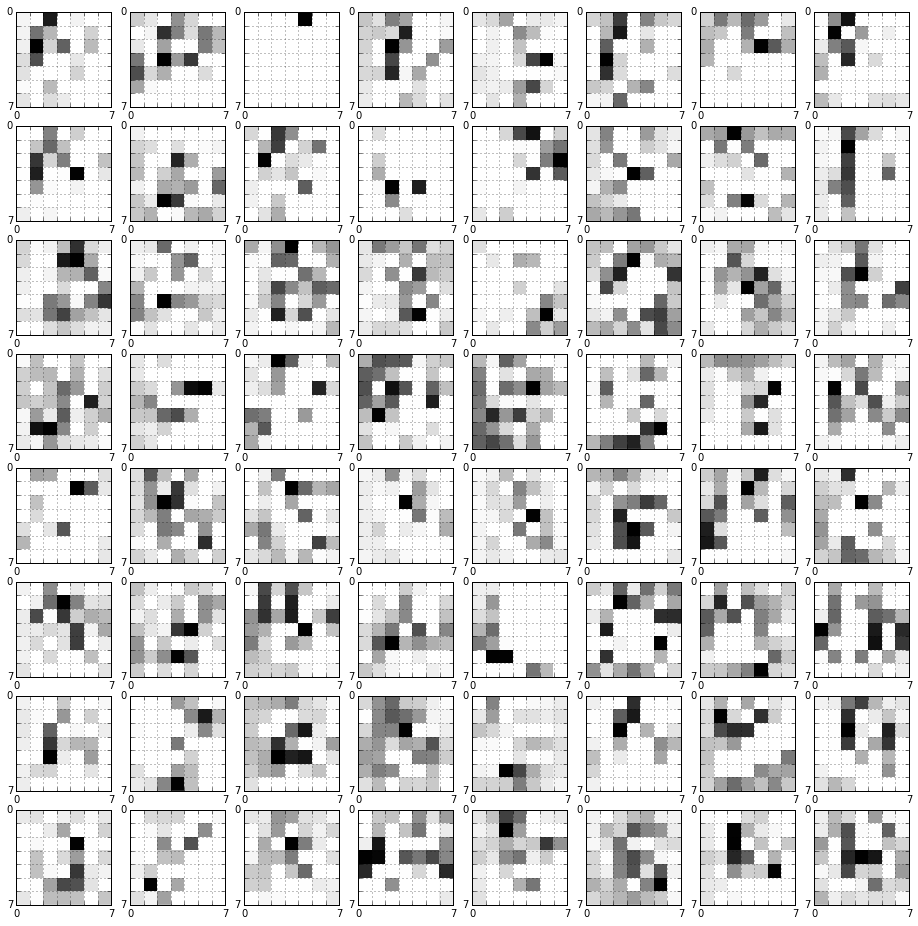

In [15]:
show_samples(_tmp.reshape(-1, 64).T, n=8)

In [ ]:
%time accuracy.eval({x: mnist.original.test[:1000], keep_prob: 5, y_: one_hot(mnist.labels.test[:1000])})